# project untitled
## куда я жмяв

### Техническое задание Маркетинг

### Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.
### Цель
Предсказать вероятность покупки в течение 90 дней
### Задачи
* Изучить данные
* Разработать полезные признаки
* Создать модель для классификации пользователей
* Улучшить модель и максимизировать метрику roc_auc
* Выполнить тестирование

### Загрузка данных

In [2]:
!pip install --upgrade pandas


In [3]:
!pip install  matplotlib 


In [42]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.utils import resample

from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import catboost



In [43]:
print(pd.__version__)

2.3.0+4.g1dfc98e16a


In [44]:
# Основная директория
#base_path = '/Users/migdalia/goinfre/description/filtered_data'
base_path = '/Users/shogun/Desktop/ds_projects/masterskaya2/filtered_data'

# Файлы
file1 = 'apparel-messages.csv'
file2 = 'apparel-purchases.csv'
file3 = 'apparel-target_binary.csv'
file4 = 'full_campaign_daily_event_channel.csv'
file5 = 'full_campaign_daily_event.csv'

# Полные пути
path1 = os.path.join(base_path, file1)
path2 = os.path.join(base_path, file2)
path3 = os.path.join(base_path, file3)
path4 = os.path.join(base_path, file4)
path5 = os.path.join(base_path, file5)

In [45]:
# Загрузка с проверкой
if os.path.exists(path1):
    apparel_messages = pd.read_csv(path1)
    print('[OK1] Загружен apparel-messages.csv')
else:
    print(f'[ОШИБКА1] {file1} не найден')

    
if os.path.exists(path2):
    apparel_purchases = pd.read_csv(path2)
    print(f'[OK2] Загружен {file2}')
else:
    print(f'[ОШИБКА2] {file2} не найден')

if os.path.exists(path3):
    apparel_target_binary = pd.read_csv(path3)
    print(f'[OK3] Загружен {file3}')
else:
    print(f'[ОШИБКА3] {file3} не найден')

    
if os.path.exists(path4):
    full_campaign_daily_event_channel = pd.read_csv(path4)
    print(f'[OK4] Загружен {file4}')
else:
    print(f'[ОШИБКА4] {file4} не найден')
    
if os.path.exists(path5):
    full_campaign_daily_event = pd.read_csv(path5)
    print(f'[OK5] Загружен {file5}')
else:
    print(f'[ОШИБКА5] {file5} не найден')

[OK1] Загружен apparel-messages.csv
[OK2] Загружен apparel-purchases.csv
[OK3] Загружен apparel-target_binary.csv
[OK4] Загружен full_campaign_daily_event_channel.csv
[OK5] Загружен full_campaign_daily_event.csv


### 1. Данные о покупках apparel-purchases. 
Это уже последствия рассылок.



In [46]:
apparel_purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


In [47]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [48]:
apparel_purchases.client_id.nunique()

49849

In [49]:
apparel_purchases.quantity.nunique()

16

In [50]:
apparel_purchases.quantity.unique() # количество единиц товара

array([ 1,  2,  3, 10,  4, 25, 20, 13, 30, 15,  6, 18,  8,  9,  5,  7])

In [51]:
apparel_purchases.price.nunique()

3642

In [52]:
apparel_purchases.category_ids.nunique()

933

In [53]:
apparel_purchases.date.nunique()

642

In [54]:
apparel_purchases.date.unique()

array(['2022-05-16', '2022-05-17', '2022-05-18', '2022-05-19',
       '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-23',
       '2022-05-24', '2022-05-25', '2022-05-26', '2022-05-27',
       '2022-05-28', '2022-05-29', '2022-05-30', '2022-05-31',
       '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
       '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
       '2022-06-09', '2022-06-10', '2022-06-11', '2022-06-12',
       '2022-06-13', '2022-06-14', '2022-06-15', '2022-06-16',
       '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20',
       '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24',
       '2022-06-25', '2022-06-26', '2022-06-27', '2022-06-28',
       '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-02',
       '2022-07-03', '2022-07-04', '2022-07-05', '2022-07-06',
       '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10',
       '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
       '2022-07-15', '2022-07-16', '2022-07-17', '2022-

In [55]:
# Переведем в datetime
apparel_purchases['date'] = pd.to_datetime(apparel_purchases['date'])

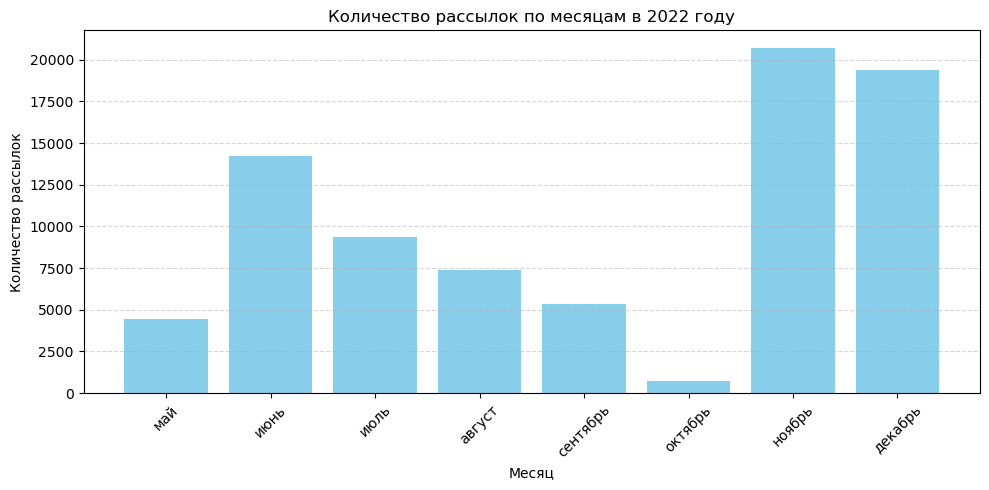

In [56]:
# Оставим только 2022 год
df_2022 = apparel_purchases[apparel_purchases['date'].dt.year == 2022]

# Группируем по месяцу и считаем количество записей
monthly_counts = df_2022['date'].dt.month.value_counts().sort_index()

# Словарь для перевода номеров месяцев в названия
month_names = {
    1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель', 5: 'май', 6: 'июнь',
    7: 'июль', 8: 'август', 9: 'сентябрь', 10: 'октябрь', 11: 'ноябрь', 12: 'декабрь'
}

# Подписи на русском
month_labels = [month_names[m] for m in monthly_counts.index]

# Построим график
plt.figure(figsize=(10, 5))
plt.bar(month_labels, monthly_counts.values, color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Количество рассылок')
plt.title('Количество рассылок по месяцам в 2022 году')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

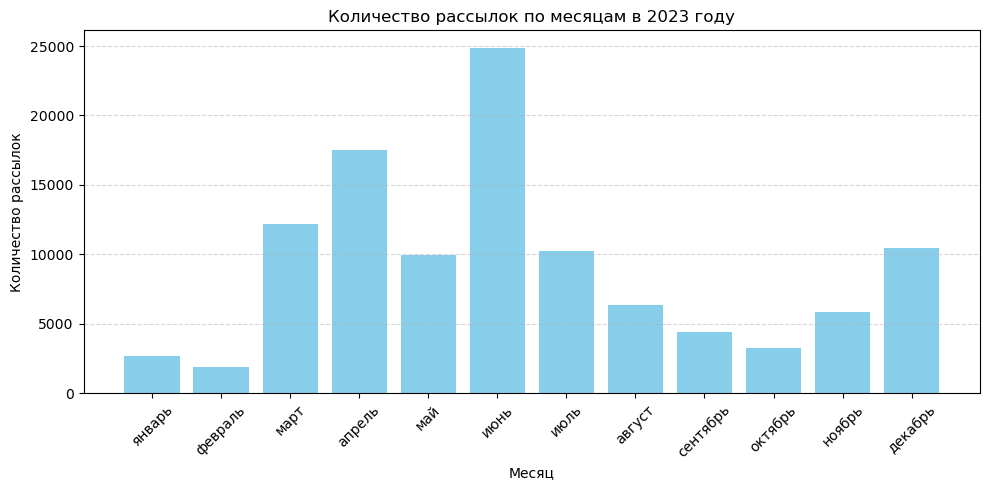

In [57]:
# Оставим только 2023 год
df_2023 = apparel_purchases[apparel_purchases['date'].dt.year == 2023]


# Группируем по месяцу и считаем количество записей
monthly_counts = df_2023['date'].dt.month.value_counts().sort_index()

# Словарь для перевода номеров месяцев в названия
month_names = {
    1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель', 5: 'май', 6: 'июнь',
    7: 'июль', 8: 'август', 9: 'сентябрь', 10: 'октябрь', 11: 'ноябрь', 12: 'декабрь'
}

# Подписи на русском
month_labels = [month_names[m] for m in monthly_counts.index]

# Построим график
plt.figure(figsize=(10, 5))
plt.bar(month_labels, monthly_counts.values, color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Количество рассылок')
plt.title('Количество рассылок по месяцам в 2023 году')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

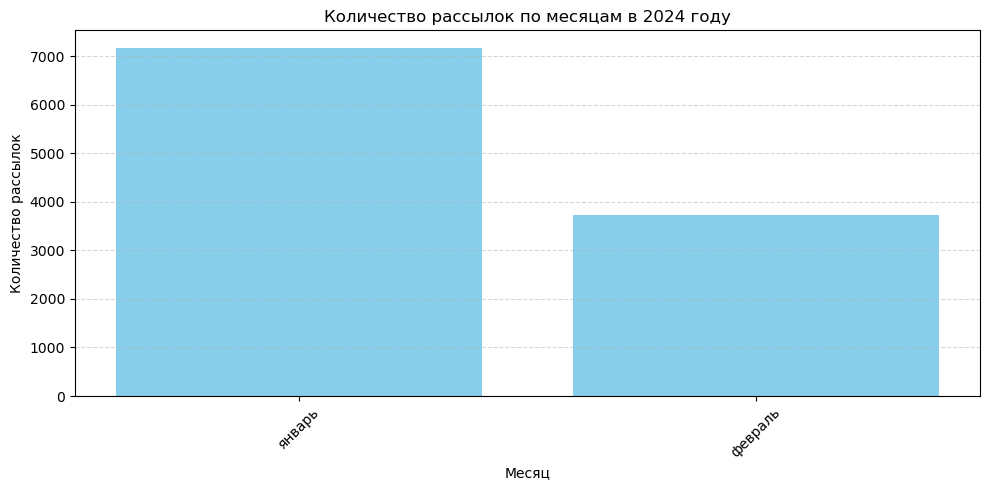

In [58]:
# Оставим только 2024 год
df_2024 = apparel_purchases[apparel_purchases['date'].dt.year == 2024]


# Группируем по месяцу и считаем количество записей
monthly_counts = df_2024['date'].dt.month.value_counts().sort_index()

# Словарь для перевода номеров месяцев в названия
month_names = {
    1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель', 5: 'май', 6: 'июнь',
    7: 'июль', 8: 'август', 9: 'сентябрь', 10: 'октябрь', 11: 'ноябрь', 12: 'декабрь'
}

# Подписи на русском
month_labels = [month_names[m] for m in monthly_counts.index]

# Построим график
plt.figure(figsize=(10, 5))
plt.bar(month_labels, monthly_counts.values, color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Количество рассылок')
plt.title('Количество рассылок по месяцам в 2024 году')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [59]:
apparel_purchases.message_id.nunique()

50204

In [60]:
apparel_purchases.message_id.unique()

array(['1515915625468169594-4301-627b661e9736d',
       '1515915625471138230-4437-6282242f27843',
       '1515915625471640575-4301-627b661b67ac3', ...,
       '1515915626009802894-14633-65c9d0647754c',
       '1515915626010221592-14664-65cf1622434a9',
       '1515915626010261344-14648-65cdb6d56c4c8'], dtype=object)

### 2. Данные о рекламных рассылках apparel-messages

In [61]:
apparel_messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [62]:
apparel_messages.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


In [63]:
apparel_messages.bulk_campaign_id.nunique()

2709

In [64]:
apparel_messages.channel.unique()

array(['email', 'mobile_push'], dtype=object)

In [65]:
apparel_messages.channel.value_counts()

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

In [66]:
apparel_messages.event.value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [67]:
apparel_messages.bulk_campaign_id.nunique()

2709

In [68]:
apparel_messages.shape[0]

12739798

In [69]:
apparel_messages.client_id.nunique()

53329

### 3. Совершит ли клиент покупку в течение следующих 90 дней

 ### целевая переменная: будет ли покупка в течение 90 дней в будущем (после отправки).

In [70]:
apparel_target_binary.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [71]:
apparel_target_binary.client_id.nunique()

49849

In [72]:
apparel_target_binary.shape[0]

49849

In [73]:
apparel_target_binary.target.value_counts()

target
0    48888
1      961
Name: count, dtype: int64

### 4. Агрегация общей базы рассылок по дням и типам событий

In [74]:
full_campaign_daily_event_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
full_campaign_daily_event_channel.columns

Index(['date', 'bulk_campaign_id', 'count_click_email',
       'count_click_mobile_push', 'count_open_email', 'count_open_mobile_push',
       'count_purchase_email', 'count_purchase_mobile_push',
       'count_soft_bounce_email', 'count_subscribe_email',
       'count_unsubscribe_email', 'nunique_click_email',
       'nunique_click_mobile_push', 'nunique_open_email',
       'nunique_open_mobile_push', 'nunique_purchase_email',
       'nunique_purchase_mobile_push', 'nunique_soft_bounce_email',
       'nunique_subscribe_email', 'nunique_unsubscribe_email',
       'count_hard_bounce_mobile_push', 'count_send_mobile_push',
       'nunique_hard_bounce_mobile_push', 'nunique_send_mobile_push',
       'count_hard_bounce_email', 'count_hbq_spam_email', 'count_send_email',
       'nunique_hard_bounce_email', 'nunique_hbq_spam_email',
       'nunique_send_email', 'count_soft_bounce_mobile_push',
       'nunique_soft_bounce_mobile_push', 'count_complain_email',
       'nunique_complain_email', 

In [76]:
full_campaign_daily_event_channel.shape[0]

131072

In [77]:
full_campaign_daily_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

### 5. Агрегация по дням с учетом событий и каналов рассылки

In [78]:
full_campaign_daily_event.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [79]:
full_campaign_daily_event.columns

Index(['date', 'bulk_campaign_id', 'count_click', 'count_complain',
       'count_hard_bounce', 'count_open', 'count_purchase', 'count_send',
       'count_soft_bounce', 'count_subscribe', 'count_unsubscribe',
       'nunique_click', 'nunique_complain', 'nunique_hard_bounce',
       'nunique_open', 'nunique_purchase', 'nunique_send',
       'nunique_soft_bounce', 'nunique_subscribe', 'nunique_unsubscribe',
       'count_hbq_spam', 'nunique_hbq_spam', 'count_close', 'nunique_close'],
      dtype='object')

In [80]:
full_campaign_daily_event.shape[0]

131072

In [81]:
full_campaign_daily_event.bulk_campaign_id.nunique()

3181

In [82]:
full_campaign_daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

## Создание фичей:

In [83]:
# Кол-во сообщений, открытий, кликов, покупок по клиенту
message_stats = apparel_messages.groupby('client_id')['event'].value_counts().unstack(fill_value=0).reset_index()


In [84]:
message_stats

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,6,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,163,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,0,0,0,0,0,2,0,2,0,0,0
53325,1515915626010221592,3,0,0,0,0,2,0,2,0,0,0
53326,1515915626010234726,0,0,0,0,0,0,0,1,0,0,0
53327,1515915626010261344,1,0,0,0,0,1,0,1,0,0,0


In [85]:
channel_counts = apparel_messages.groupby('client_id')['channel'].value_counts().unstack(fill_value=0).reset_index()


In [86]:
channel_counts

channel,client_id,email,mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,166,0
2,1515915625468061099,182,94
3,1515915625468061100,0,434
4,1515915625468061170,202,91
...,...,...,...
53324,1515915626010183608,0,4
53325,1515915626010221592,0,7
53326,1515915626010234726,0,1
53327,1515915626010261344,0,3


In [87]:
purchase_stats = apparel_purchases.groupby('client_id').agg({
    'price': 'sum',
    'quantity': 'sum',
    'message_id': 'count'
}).rename(columns={
    'price': 'total_spent',
    'quantity': 'total_items',
    'message_id': 'num_purchases'
}).reset_index()


In [88]:
purchase_stats

,client_id,total_spent,total_items,num_purchases
0,1515915625468060902,6993.0,7,7
1,1515915625468061003,16235.0,7,7
2,1515915625468061099,299.0,1,1
3,1515915625468061100,2098.0,2,2
4,1515915625468061170,33601.0,19,19
...,...,...,...,...
49844,1515915626010261344,8994.0,6,6
49845,1515915626010266132,1818.0,2,2
49846,1515915626010439406,198.0,2,2
49847,1515915626010443527,1999.0,1,1


In [89]:



# список таблиц по client_id
tables = [message_stats, channel_counts, purchase_stats, apparel_target_binary]

# последовательное объединение
df_merged = reduce(lambda left, right: pd.merge(left, right, on='client_id', how='left'), tables)


In [90]:
df_merged

,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,email,mobile_push,total_spent,total_items,num_purchases,target
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1,177,0,6993.0,7.0,7.0,0.0
1,1515915625468061003,6,0,0,0,0,5,1,154,0,0,0,166,0,16235.0,7.0,7.0,1.0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0,182,94,299.0,1.0,1.0,0.0
3,1515915625468061100,1,0,0,1,0,163,1,267,1,0,0,0,434,2098.0,2.0,2.0,0.0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0,202,91,33601.0,19.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,0,0,0,0,0,2,0,2,0,0,0,0,4,568.0,4.0,4.0,0.0
53325,1515915626010221592,3,0,0,0,0,2,0,2,0,0,0,0,7,2998.0,2.0,2.0,0.0
53326,1515915626010234726,0,0,0,0,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN
53327,1515915626010261344,1,0,0,0,0,1,0,1,0,0,0,0,3,8994.0,6.0,6.0,0.0


In [91]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   client_id      53329 non-null  int64  
 1   click          53329 non-null  int64  
 2   close          53329 non-null  int64  
 3   complain       53329 non-null  int64  
 4   hard_bounce    53329 non-null  int64  
 5   hbq_spam       53329 non-null  int64  
 6   open           53329 non-null  int64  
 7   purchase       53329 non-null  int64  
 8   send           53329 non-null  int64  
 9   soft_bounce    53329 non-null  int64  
 10  subscribe      53329 non-null  int64  
 11  unsubscribe    53329 non-null  int64  
 12  email          53329 non-null  int64  
 13  mobile_push    53329 non-null  int64  
 14  total_spent    41982 non-null  float64
 15  total_items    41982 non-null  float64
 16  num_purchases  41982 non-null  float64
 17  target         41982 non-null  float64
dtypes: flo

In [92]:
df_merged = df_merged.fillna(0)


In [93]:
print(df_merged.shape)
print(df_merged.columns)
print(df_merged['target'].value_counts())


(53329, 18)
Index(['client_id', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam',
       'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe',
       'email', 'mobile_push', 'total_spent', 'total_items', 'num_purchases',
       'target'],
      dtype='object')
target
0.0    52483
1.0      846
Name: count, dtype: int64


In [94]:

X = df_merged.drop(columns=['target'])
y = df_merged['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [95]:

# Объединяем X и y обратно
train = pd.concat([X_train, y_train], axis=1)

# Делим по классам
majority = train[train.target == 0]
minority = train[train.target == 1]

# Oversample minority
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Объединяем
train_balanced = pd.concat([majority, minority_upsampled])

# Обратно разбиваем
X_train_bal = train_balanced.drop(columns=['target'])
y_train_bal = train_balanced['target']


In [96]:


model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)

#print(classification_report(y_test, y_pred, digits=3))

y_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.5000


In [97]:
!pip install catboost

In [98]:
!pip install numpy==1.26.4


In [99]:
#print(np.__version__)

In [100]:

#print(catboost.__version__)


In [102]:


cat_model = catboost.CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    verbose=100,
    random_seed=42,
    #eval_metric='F1',
    eval_metric='AUC',
    task_type='CPU'  # или GPU, если доступен
)

cat_model.fit(X_train_bal, y_train_bal, eval_set=(X_test, y_test), early_stopping_rounds=300)


0:	test: 0.7647826	best: 0.7647826 (0)	total: 69.6ms	remaining: 2m 19s
100:	test: 0.7774952	best: 0.7875739 (3)	total: 1.29s	remaining: 24.3s
200:	test: 0.7669303	best: 0.7875739 (3)	total: 2.5s	remaining: 22.4s
300:	test: 0.7456788	best: 0.7875739 (3)	total: 3.69s	remaining: 20.9s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7875738518
bestIteration = 3

Shrink model to first 4 iterations.


In [103]:
X_train_bal.head()

,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,email,mobile_push,total_spent,total_items,num_purchases
44986,1515915625795092454,18,0,0,0,0,0,1,274,0,0,0,0,293,3358.0,6.0,6.0
437,1515915625468090684,3,0,0,2,0,67,2,145,0,0,0,209,10,8955.0,5.0,5.0
30493,1515915625559544104,4,0,0,2,0,132,1,319,0,0,1,134,325,8694.0,6.0,6.0
15197,1515915625490140743,1,0,0,0,0,13,1,95,0,0,0,53,57,7978.0,4.0,4.0
14522,1515915625489925034,9,0,0,0,0,3,2,76,0,0,0,61,29,4594.0,8.0,8.0


In [104]:
y_proba = cat_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.7876


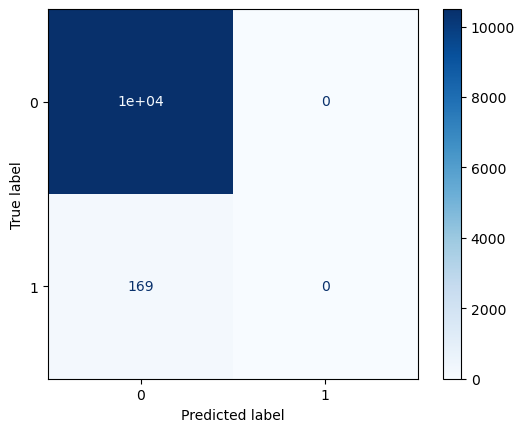

In [105]:

# Предсказания модели
y_pred2 = model.predict(X_test)

# Вычисляем confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Визуализируем
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


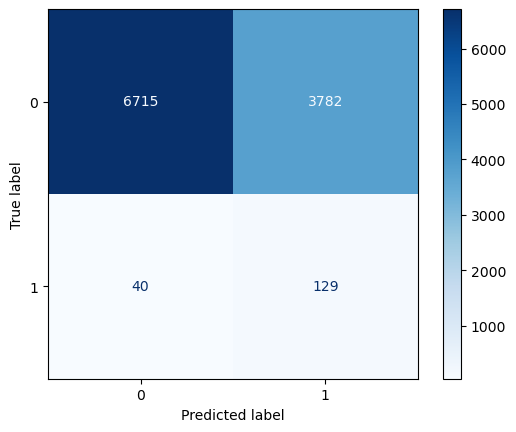

In [106]:

# Предсказания модели
y_pred3 = cat_model.predict(X_test)

# Вычисляем confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Визуализируем
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [107]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6715 3782]
 [  40  129]]


/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shogun/anaconda3/envs/kaggle/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

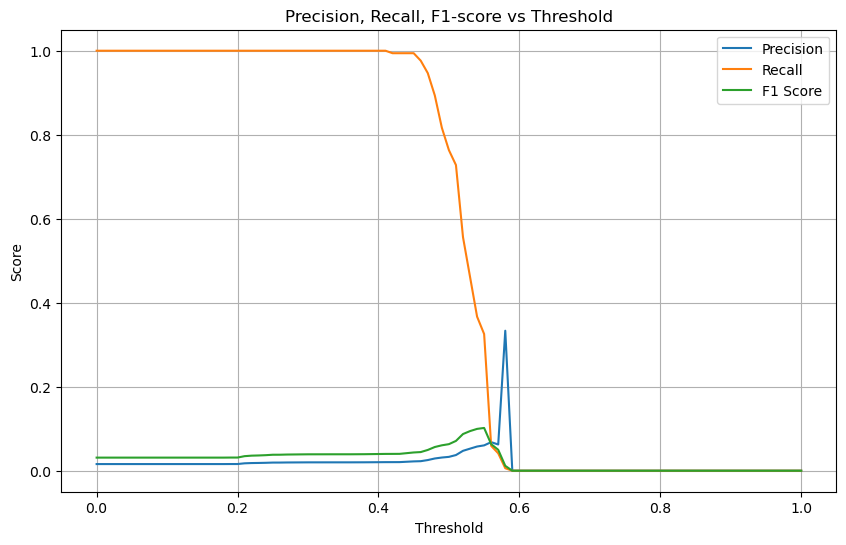

In [108]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

#y_proba = model.predict_proba(X_test)[:, 1]
#y_pred3 = cat_model.predict(X_test)
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred3 = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred3))
    recalls.append(recall_score(y_test, y_pred3))
    f1_scores.append(f1_score(y_test, y_pred3))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [109]:
best_threshold = 0.0
best_f1 = 0.0

for t in np.arange(0, 1.01, 0.01):
    y_pred3 = (y_proba >= t).astype(int)
    current_f1 = f1_score(y_test, y_pred3)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = t

print(f"Лучший порог: {best_threshold:.2f} с F1 = {best_f1:.3f}")

Лучший порог: 0.55 с F1 = 0.102


In [110]:

y_proba = cat_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Youden's J statistic
J = tpr - fpr

ix = J.argmax()
best_thresh = thresholds[ix]

print(f"Оптимальный порог по Youden’s J: {best_thresh:.3f}")
print(f"TPR (чувствительность) = {tpr[ix]:.3f}, FPR = {fpr[ix]:.3f}")


Оптимальный порог по Youden’s J: 0.510
TPR (чувствительность) = 0.722, FPR = 0.290


In [111]:
# Получаем вероятности положительного класса
y_proba = cat_model.predict_proba(X_test)[:, 1]

# Применяем порог 0.284
threshold = 0.284
y_pred = (y_proba >= threshold).astype(int)

# Строим confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix при пороге 0.284:")
print(cm)

Confusion Matrix при пороге 0.284:
[[2144 8353]
 [   0  169]]


**Анализ**

- Класс 1 (покупка) редкий и плохо распознаётся: всего 63 из (63+106)=169 положительных распознано.

- Много ложных срабатываний (FP=1121), то есть модель часто ошибается, выдавая покупку там, где её нет.

- Показатель полноты (recall) для класса 1 = TP / (TP + FN) = 63 / (63+106) ≈ 0.37 — плохо.

- Точность (precision) для класса 1 = TP / (TP + FP) = 63 / (63+1121) ≈ 0.053 — очень низкая.